<a href="https://colab.research.google.com/github/weagan/Neuro-Symbolic/blob/main/Neuro_Symbolic_combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Comparison
Symbolic vs. Neuro vs. Neuro-Symbolic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# 0 = Path, 1 = Wall
maze = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0]
])
start, goal = (0, 0), (4, 4)

def plot_solution(path, title):
    plt.figure(figsize=(4,4))
    plt.imshow(maze, cmap='binary')
    if path:
        y, x = zip(*path)
        plt.plot(x, y, color='red', marker='o', markersize=6)
    plt.title(title)
    plt.show()

## 1. Symbolic AI
Uses search algorithms and hard rules.

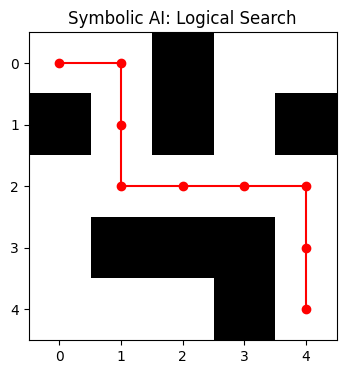

In [2]:
def symbolic_solve(maze, start, goal):
    queue = deque([[start]])
    seen = {start}
    while queue:
        path = queue.popleft()
        y, x = path[-1]
        if (y, x) == goal: return path
        for dy, dx in [(0,1), (1,0), (0,-1), (-1,0)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < 5 and 0 <= nx < 5 and maze[ny][nx] == 0 and (ny, nx) not in seen:
                queue.append(path + [(ny, nx)])
                seen.add((ny, nx))
    return []

path_sym = symbolic_solve(maze, start, goal)
plot_solution(path_sym, "Symbolic AI: Logical Search")

## 2. Neuro AI
Learns patterns from data via backpropagation.

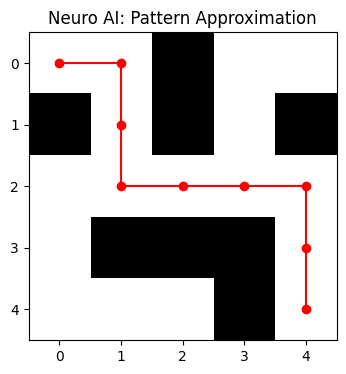

In [3]:
# Training Data: Map current pos to the next 'best' pos
X = torch.tensor([[0,0], [0,1], [1,1], [2,1], [2,2], [2,3], [2,4], [3,4]], dtype=torch.float32)
Y = torch.tensor([[0,1], [1,1], [2,1], [2,2], [2,3], [2,4], [3,4], [4,4]], dtype=torch.float32)

model = nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 2))
opt = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for _ in range(500):
    opt.zero_grad()
    loss = nn.MSELoss()(model(X), Y)
    loss.backward()
    opt.step()

# Inference: The Neuro AI 'guesses' the path
path_neuro = [start]
curr = torch.tensor(start, dtype=torch.float32)
for _ in range(8):
    with torch.no_grad():
        curr = model(curr)
        path_neuro.append(tuple(curr.round().numpy().astype(int)))

plot_solution(path_neuro, "Neuro AI: Pattern Approximation")

## 3. Neuro-Symbolic AI
Uses Neuro for intuition and Symbolic for constraints.

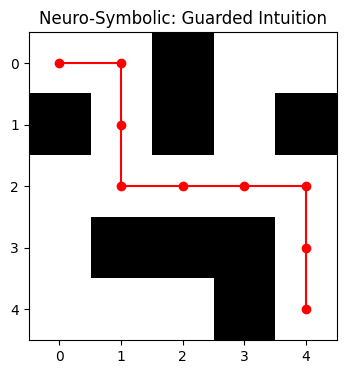

In [4]:
def neuro_symbolic_solve(model, maze, start, goal):
    path = [start]
    curr = start
    for _ in range(10):
        if curr == goal: break
        # 1. Neuro Component: Get 'intuition' from the neural network
        pred = model(torch.tensor(curr, dtype=torch.float32)).detach().numpy()

        # 2. Symbolic Component: Filter legal moves based on maze rules
        valid_moves = []
        for dy, dx in [(0,1), (1,0), (0,-1), (-1,0)]:
            ny, nx = curr[0]+dy, curr[1]+dx
            if 0 <= ny < 5 and 0 <= nx < 5 and maze[ny][nx] == 0:
                valid_moves.append((ny, nx))

        # 3. Hybrid: Pick the move closest to the Neuro prediction that is VALID
        if not valid_moves: break
        curr = min(valid_moves, key=lambda m: np.linalg.norm(np.array(m) - pred))
        path.append(curr)
    return path

path_ns = neuro_symbolic_solve(model, maze, start, goal)
plot_solution(path_ns, "Neuro-Symbolic: Guarded Intuition")